In [1]:
!pip install numpy==1.23.5  # Version known to work with scikit-learn-extra
!pip install scikit-learn-extra

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
sns.set_palette("viridis")


In [3]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
sf_crime_path = kagglehub.competition_download('sf-crime')

print('Data source import complete.')

100%|██████████| 40.9M/40.9M [00:00<00:00, 167MB/s]

Extracting files...


Data source import complete.


In [6]:
df = pd.read_csv(f'{sf_crime_path}/train.csv.zip', parse_dates=['Dates'])
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Information:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

Dataset Shape: (878049, 9)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   Descript    878049 non-null  object        
 3   DayOfWeek   878049 non-null  object        
 4   PdDistrict  878049 non-null  object        
 5   Resolution  878049 non-null  object        
 6   Address     878049 non-null  object        
 7   X           878049 non-null  float64       
 8   Y           878049 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB

Missing Values:
Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

Summary Statistics:
                               Date

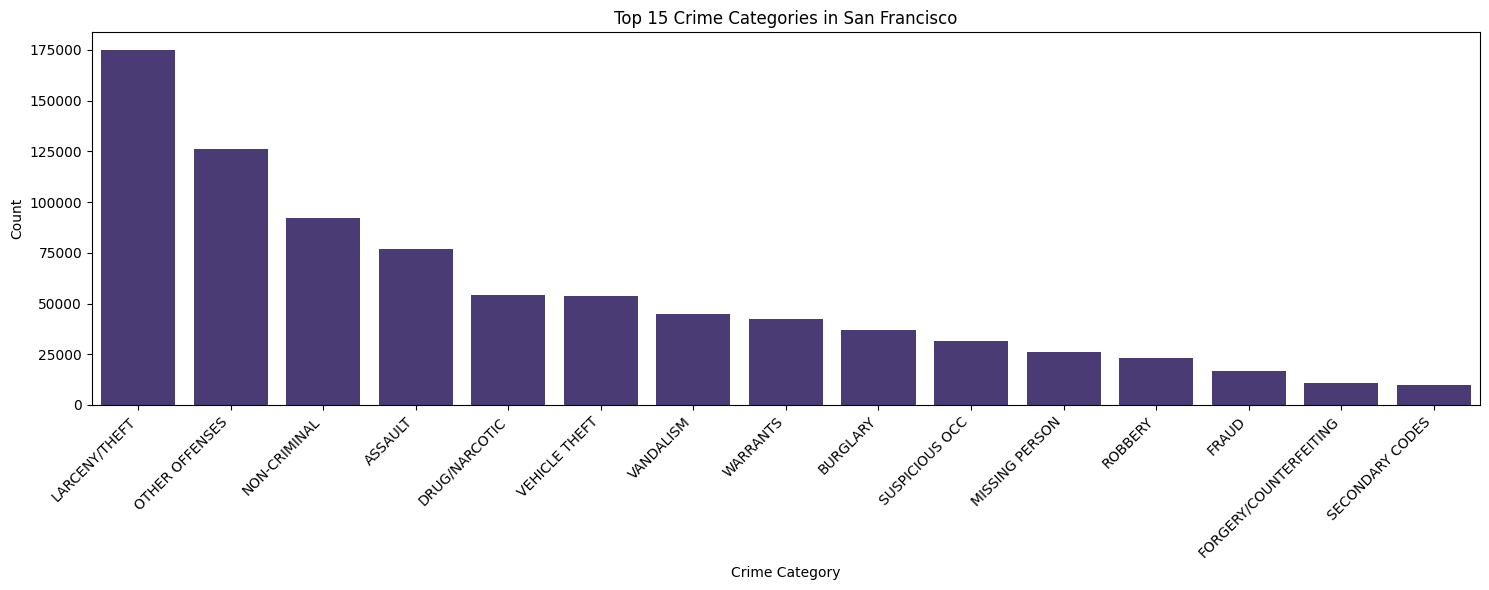

In [8]:
# Visualize the distribution of crime categories
plt.figure(figsize=(15, 6))
category_counts = df['Category'].value_counts().sort_values(ascending=False)
top_categories = category_counts.head(15)
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Top 15 Crime Categories in San Francisco')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

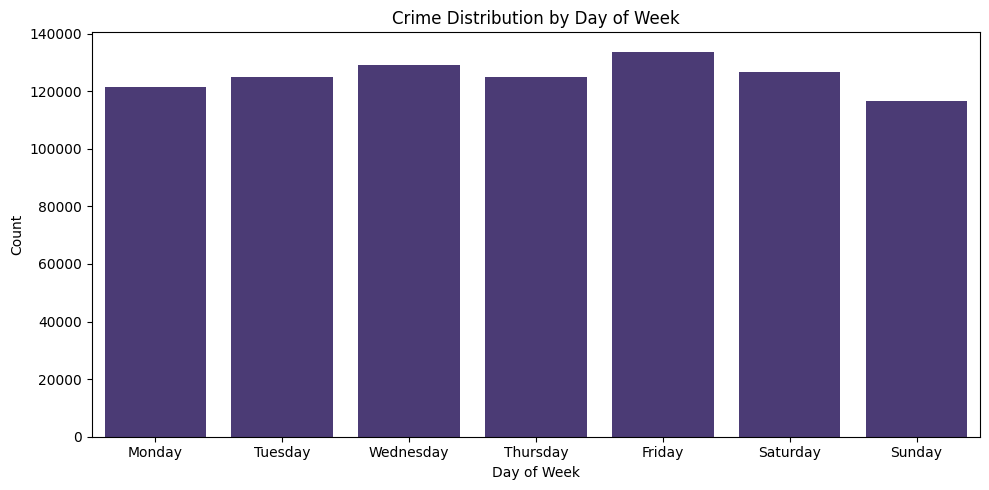

In [9]:
# Visualize crime distribution by day of week
plt.figure(figsize=(10, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['DayOfWeek'].value_counts().reindex(day_order)
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Crime Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

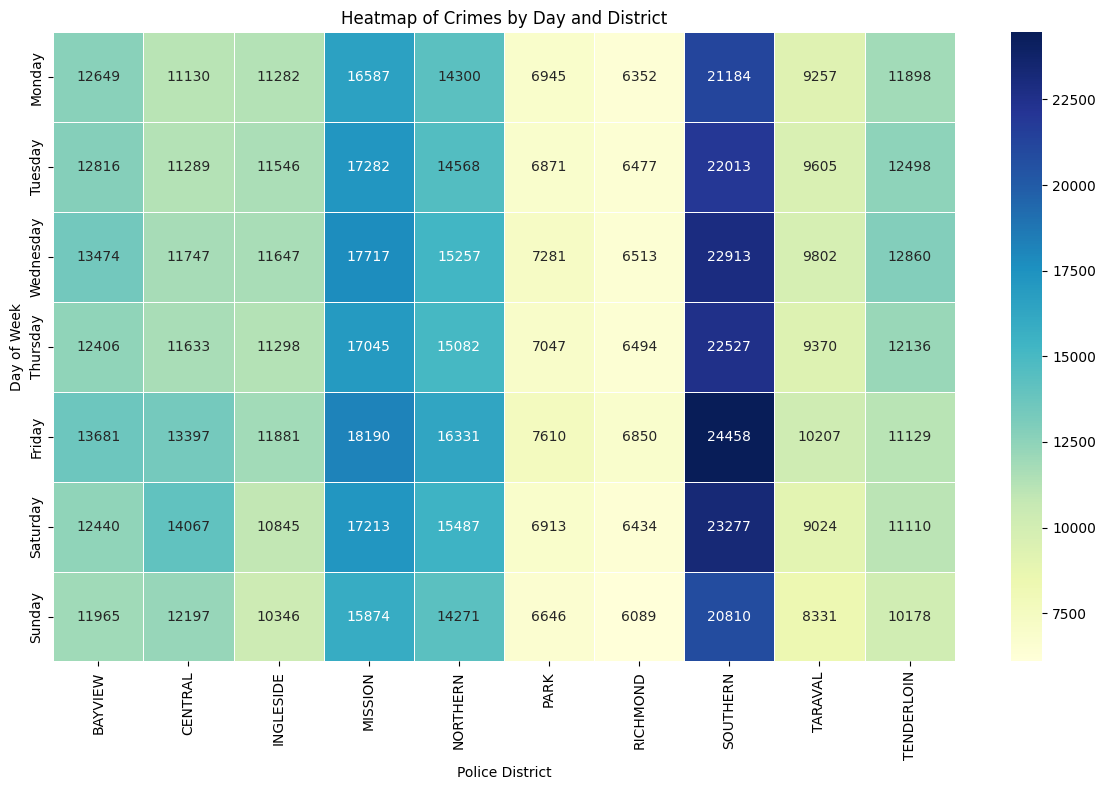

In [10]:
# Create a heatmap showing crimes by day and district
if 'DayOfWeek' in df.columns and 'PdDistrict' in df.columns:
    day_district = pd.crosstab(df['DayOfWeek'], df['PdDistrict'])
    day_district = day_district.reindex(day_order)

    plt.figure(figsize=(12, 8))
    sns.heatmap(day_district, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
    plt.title('Heatmap of Crimes by Day and District')
    plt.xlabel('Police District')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.show()

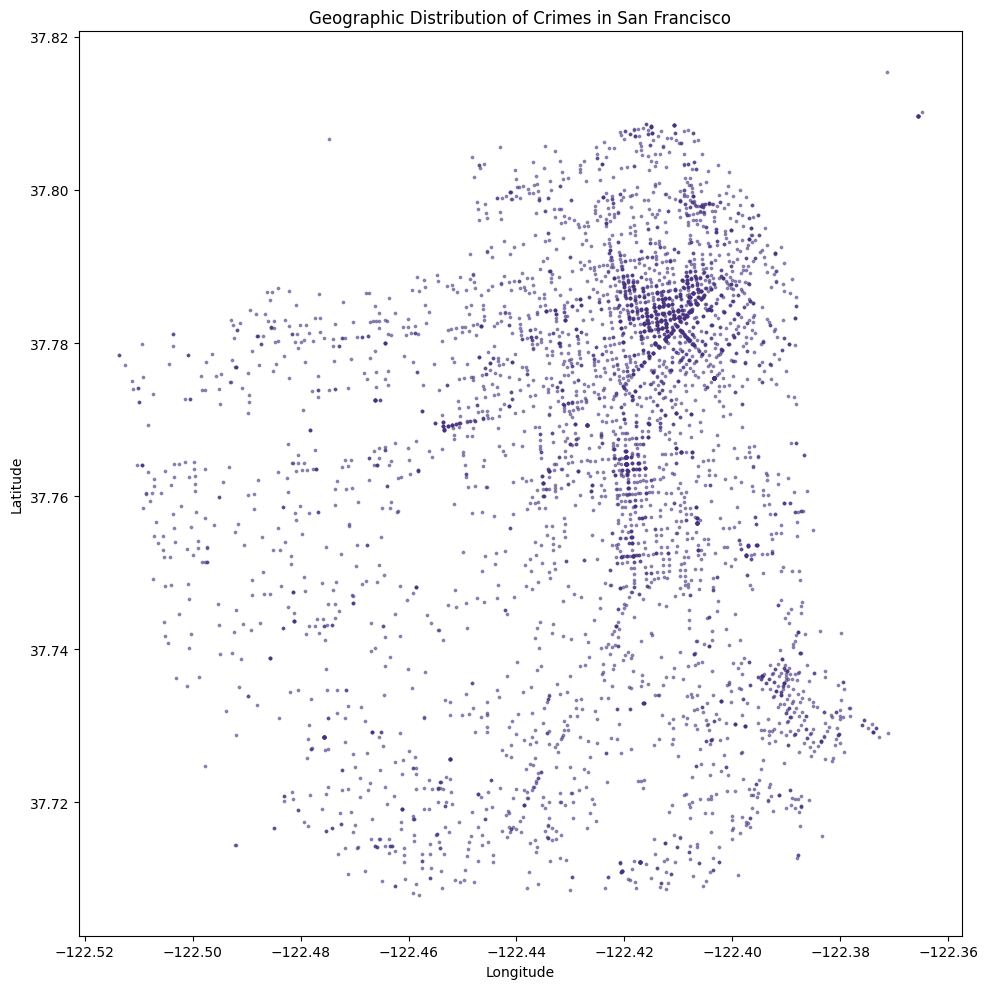

In [11]:
# Geographic visualization of crimes
if 'X' in df.columns and 'Y' in df.columns:
    # Filter out any rows with invalid coordinates
    geo_df = df.dropna(subset=['X', 'Y'])
    geo_df = geo_df[(geo_df['X'] != 0) & (geo_df['Y'] != 0)]

    # Sample a subset of the data for better visualization if dataset is large
    if len(geo_df) > 5000:
        geo_df = geo_df.sample(5000, random_state=42)

    plt.figure(figsize=(10, 10))
    plt.scatter(geo_df['X'], geo_df['Y'], alpha=0.5, s=3)
    plt.title('Geographic Distribution of Crimes in San Francisco')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

    # Optional: If you have folium installed, create an interactive map
    try:
        import folium
        from folium.plugins import HeatMap

        # Create a base map centered on San Francisco
        sf_map = folium.Map(location=[37.77, -122.42], zoom_start=12)

        # Add a heatmap layer
        heat_data = [[row['Y'], row['X']] for _, row in geo_df.iterrows()]
        HeatMap(heat_data).add_to(sf_map)


    except ImportError:
        print("Folium is not installed. To create interactive maps, install folium with 'pip install folium'")

In [12]:
# Function to convert datetime to numerical features
def process_datetime(df):
    if 'Dates' in df.columns:
        # Convert date column to datetime format if it's not already
        if not pd.api.types.is_datetime64_dtype(df['Dates']):
            df['Dates'] = pd.to_datetime(df['Dates'], errors='coerce')

        # Extract useful datetime features
        df['Hour'] = df['Dates'].dt.hour
        df['Month'] = df['Dates'].dt.month
        df['Year'] = df['Dates'].dt.year
        df['DayOfYear'] = df['Dates'].dt.dayofyear
        df['WeekOfYear'] = df['Dates'].dt.isocalendar().week

    return df

# Process datetime features
df = process_datetime(df)

# Select relevant columns for clustering
# We'll exclude text-heavy columns like 'Descript' and 'Address'
feature_cols = []

# Add datetime-derived features
datetime_features = ['Hour', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']
feature_cols.extend([col for col in datetime_features if col in df.columns])

# Add categorical features
categorical_features = ['Category', 'DayOfWeek', 'PdDistrict', 'Resolution']
cat_cols = [col for col in categorical_features if col in df.columns]
feature_cols.extend(cat_cols)

# Add numerical features (coordinates)
numerical_features = ['X', 'Y']
num_cols = [col for col in numerical_features if col in df.columns]
feature_cols.extend(num_cols)

# Create a subset with only the selected features
df_features = df[feature_cols].copy()

# Handle missing values
df_features = df_features.dropna()

print(f"Selected features for clustering: {feature_cols}")
print(f"Shape after preprocessing: {df_features.shape}")
df_features.head()

Selected features for clustering: ['Hour', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 'Category', 'DayOfWeek', 'PdDistrict', 'Resolution', 'X', 'Y']
Shape after preprocessing: (878049, 11)


,Hour,Month,Year,DayOfYear,WeekOfYear,Category,DayOfWeek,PdDistrict,Resolution,X,Y
0,23,5,2015,133,20,WARRANTS,Wednesday,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599
1,23,5,2015,133,20,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599
2,23,5,2015,133,20,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",-122.424363,37.800414
3,23,5,2015,133,20,LARCENY/THEFT,Wednesday,NORTHERN,NONE,-122.426995,37.800873
4,23,5,2015,133,20,LARCENY/THEFT,Wednesday,PARK,NONE,-122.438738,37.771541


In [13]:
# Build preprocessing pipeline for clustering
# For categorical features: one-hot encoding
# For numerical features: standard scaling

# Define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Apply preprocessing
print("Applying preprocessing pipeline...")
X = preprocessor.fit_transform(df_features)
print(f"Data shape after preprocessing: {X.shape}")

Applying preprocessing pipeline...
Data shape after preprocessing: (878049, 75)


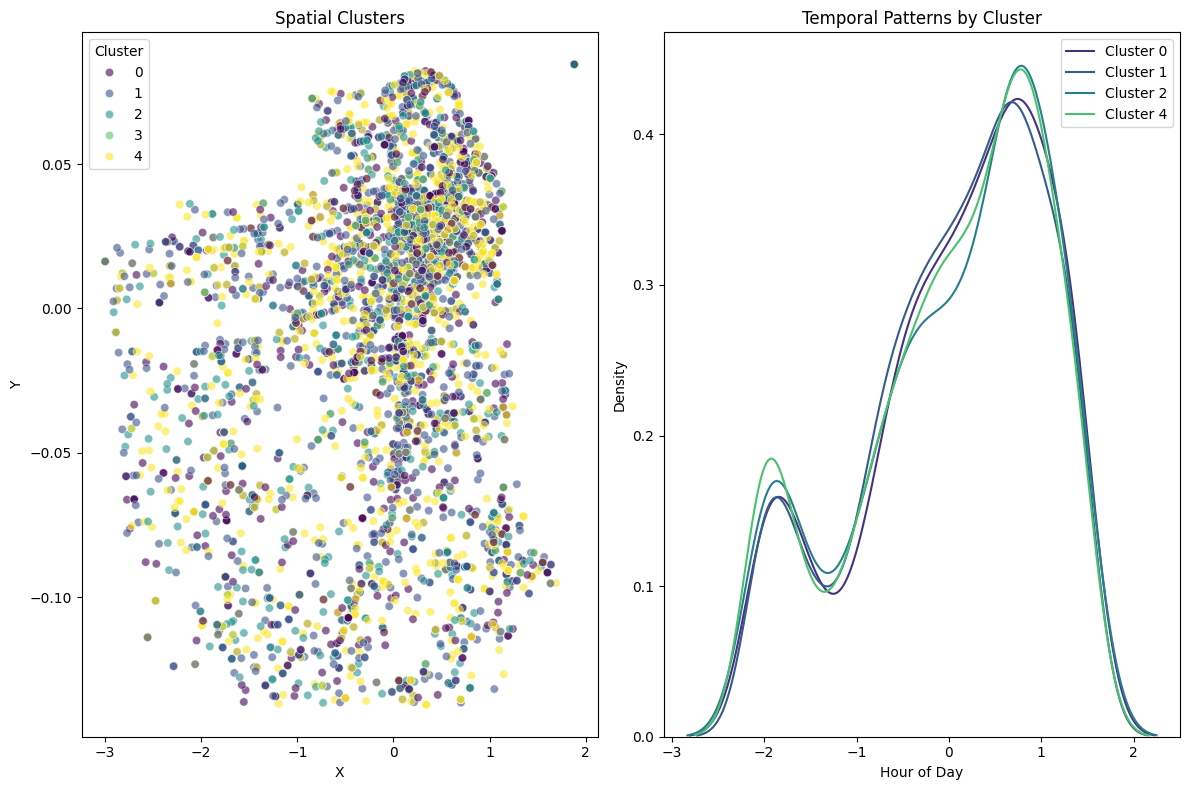


Cluster Sizes:
Cluster
4    1584
1    1540
0     950
2     925
3       1
Name: count, dtype: int64

Most Common Crime Categories per Cluster:

Cluster 0:
Category
LARCENY/THEFT     260
OTHER OFFENSES    128
NON-CRIMINAL       95
Name: count, dtype: int64

Cluster 1:
Category
LARCENY/THEFT     432
OTHER OFFENSES    194
NON-CRIMINAL      181
Name: count, dtype: int64

Cluster 2:
Category
LARCENY/THEFT     246
NON-CRIMINAL      122
OTHER OFFENSES    113
Name: count, dtype: int64

Cluster 3:
Category
LARCENY/THEFT    1
Name: count, dtype: int64

Cluster 4:
Category
LARCENY/THEFT     440
NON-CRIMINAL      204
OTHER OFFENSES    172
Name: count, dtype: int64


In [14]:
# HIERARCHICAL CLUSTERING WITH AGGLOMERATIVECLUSTERING

# 1. Reload and prepare data (ensuring clean state)
df = pd.read_csv(f'{sf_crime_path}/train.csv.zip', parse_dates=['Dates'])
df=process_datetime(df)
# 2. Select and preprocess key features
features = ['X','Y','Hour']  # Using basic spatial-temporal features
df = df[features + ['Category']].dropna()  # Ensure no missing values

# 3. Standardize numerical features
scaler = StandardScaler()
df_features = scaler.fit_transform(df[['X', 'Y','Hour']])
df[['X', 'Y','Hour']]=df_features
# 4. Sample the data if too large (AgglomerativeClustering is memory intensive)
sample_size = 5000
if len(X) > sample_size:
    X = X[np.random.choice(len(X), sample_size, replace=False)]

# 5. Perform Agglomerative Clustering
n_clusters = 5  # Start with 5 clusters
cluster_model = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage='ward'
)

# Fit and predict
cluster_labels = cluster_model.fit_predict(X)
df = df.iloc[:len(cluster_labels)].copy()  # Align with sampled data
df['Cluster'] = cluster_labels

# 6. Visualize results
plt.figure(figsize=(12, 8))

# Spatial clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x='X', y='Y', hue='Cluster', data=df, palette='viridis', alpha=0.6)
plt.title('Spatial Clusters')

# Temporal patterns
plt.subplot(1, 2, 2)
for cluster in range(n_clusters):
    sns.kdeplot(df[df['Cluster']==cluster]['Hour'], label=f'Cluster {cluster}')
plt.title('Temporal Patterns by Cluster')
plt.xlabel('Hour of Day')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Analyze cluster characteristics
print("\nCluster Sizes:")
print(df['Cluster'].value_counts())

print("\nMost Common Crime Categories per Cluster:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster']==cluster]['Category'].value_counts().head(3))

# 8. Save results
#output_file = 'sf_crime_clusters.csv'
#df.to_csv(output_file, index=False)
#print(f"\nResults saved to {output_file}")

In [15]:
# Import evaluation tools for clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

In [21]:
# Match cluster labels with original crime categories (for evaluation)
df_sampled = df.iloc[:len(cluster_labels)]  # Align sampled data with labels

# Calculate cluster quality metrics
silhouette = silhouette_score(X, cluster_labels)  # How "tight" clusters are (higher = better)
davies_bouldin = davies_bouldin_score(X, cluster_labels)  # Cluster separation (lower = better)
ari = adjusted_rand_score(df_sampled['Category'], cluster_labels)  # Matches clusters to crime categories (higher = better)

In [17]:
# Display metric scores
print(f"Silhouette Score: {silhouette:.4f}")  # >0.5 = good clusters
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")  # <1 = reasonable separation
print(f"Adjusted Rand Index: {ari:.4f}")  # >0.3 = clusters align with categories

Silhouette Score: 0.0788
Davies-Bouldin Index: 2.2377
Adjusted Rand Index: 0.0006


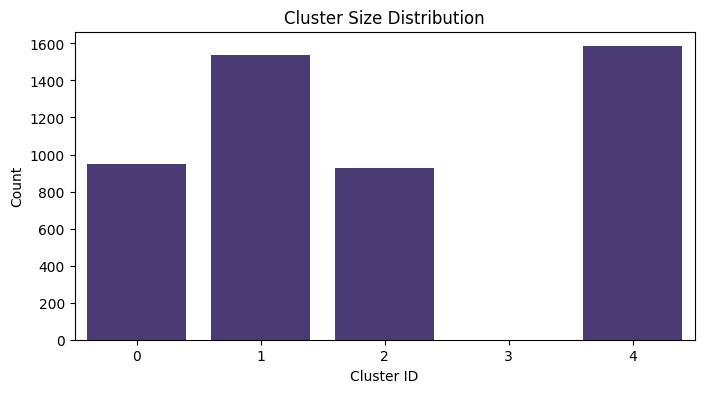

In [18]:
# Show how many crimes are in each cluster
plt.figure(figsize=(8, 4))
sns.countplot(x='Cluster', data=df_sampled)  # Count crimes per cluster
plt.title("Cluster Size Distribution")  # Do clusters have similar sizes?
plt.xlabel("Cluster ID")  # Cluster numbers (0, 1, 2...)
plt.ylabel("Count")  # Number of crimes
plt.show()

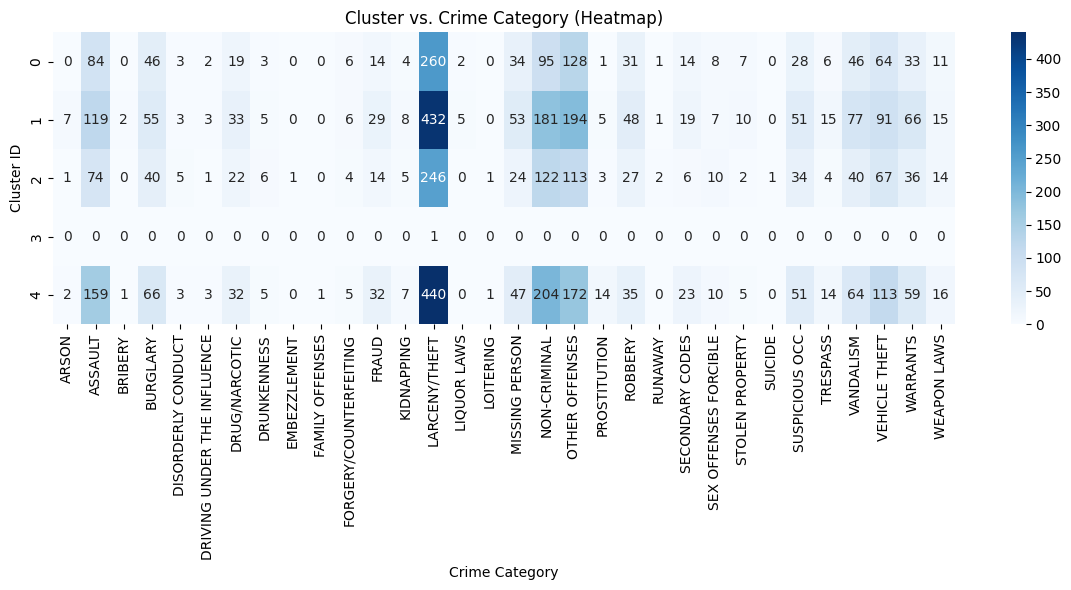

In [19]:
# Show which clusters align with which crime types
plt.figure(figsize=(12, 6))
cluster_category = pd.crosstab(df_sampled['Cluster'], df_sampled['Category'])  # Count overlaps
sns.heatmap(cluster_category, cmap="Blues", annot=True, fmt="d")  # Plot heatmap
plt.title("Cluster vs. Crime Category (Heatmap)")  # Do clusters group similar crimes?
plt.xlabel("Crime Category")  # e.g., "Larceny", "Assault"
plt.ylabel("Cluster ID")  # Cluster numbers
plt.tight_layout()
plt.show()

In [20]:
# Test another clustering method (KMedoids) for comparison
kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
kmedoids_labels = kmedoids.fit_predict(X)

# Evaluate KMedoids
silhouette_kmedoids = silhouette_score(X, kmedoids_labels)  # Tightness
ari_kmedoids = adjusted_rand_score(df_sampled['Category'], kmedoids_labels)  # Alignment

print(f"KMedoids Silhouette Score: {silhouette_kmedoids:.4f}")
print(f"KMedoids Adjusted Rand Index: {ari_kmedoids:.4f}")

KMedoids Silhouette Score: 0.0572
KMedoids Adjusted Rand Index: 0.0004
